Initialization  

In [18]:
#for all stages
import numpy as np
import pandas as pd
import re

#for plotting
import seaborn as sns
import matplotlib.pyplot as plt

#for EDA
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.preprocessing import LabelEncoder

#for machine learning section
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor


Dataset Initial Exploratory

In [19]:
#load dataset
df = pd.read_csv('C:/Users/josep/OneDrive/Desktop/small python project/Data Cleaning and EDA Practice/bi.csv',
                 encoding='latin-1')
df.head(15)

,fNAME,lNAME,Age,gender,country,residence,entryEXAM,prevEducation,studyHOURS,Python,DB
0,Christina,Binger,44,Female,Norway,Private,72,Masters,158,59.0,55
1,Alex,Walekhwa,60,M,Kenya,Private,79,Diploma,150,60.0,75
2,Philip,Leo,25,Male,Uganda,Sognsvann,55,HighSchool,130,74.0,50
3,Shoni,Hlongwane,22,F,Rsa,Sognsvann,40,High School,120,NaN,44
4,Maria,Kedibone,23,Female,South Africa,Sognsvann,65,High School,122,91.0,80
5,Hannah,Hansen,25,female,Norge,BI Residence,66,High School,130,88.0,59
6,Ole,Johansen,27,Male,Norway,BI-Residence,90,Bachelors,156,80.0,91
7,Lars,Olsen,29,Male,norway,BIResidence,89,Barrrchelors,160,85.0,60
8,Bjørn,Larsen,31,Male,Norway,BI Residence,88,Bachelors,156,80.0,89
9,Sofie,Jensen,33,Female,Denmark,BI_Residence,85,Bachelors,160,83.0,90


In [20]:
#check shape and structure
print(df.shape)     #77 rows, 11 columns
print(df.info())    #Python score stored in float instead of int

(77, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fNAME          77 non-null     object 
 1   lNAME          77 non-null     object 
 2   Age            77 non-null     int64  
 3   gender         77 non-null     object 
 4   country        77 non-null     object 
 5   residence      77 non-null     object 
 6   entryEXAM      77 non-null     int64  
 7   prevEducation  77 non-null     object 
 8   studyHOURS     77 non-null     int64  
 9   Python         75 non-null     float64
 10  DB             77 non-null     int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 6.7+ KB
None


In [21]:
#initial check on dataset to clean
#check duplicated records
df.duplicated().sum()
df[df.duplicated()]     #no duplicated records

,fNAME,lNAME,Age,gender,country,residence,entryEXAM,prevEducation,studyHOURS,Python,DB


In [22]:
#check for null values
df.isna().sum()         #only 2 null records in Python

fNAME            0
lNAME            0
Age              0
gender           0
country          0
residence        0
entryEXAM        0
prevEducation    0
studyHOURS       0
Python           2
DB               0
dtype: int64

In [23]:
#check for columns to standardize
print(df['gender'].unique())        #M, male and Male -> Male
                                    #F, female and Female -> Female

print(df['country'].unique())       #we have rsa and south africa -> same
                                    #norge and norway -> same
                                    #UK in abbreviation

print(df['residence'].unique())     #BI-Residence, BIResidence and BI_Residence to BI Residence

print(df['prevEducation'].unique())

['Female' 'M' 'Male' 'F' 'female' 'male']
['Norway' 'Kenya' 'Uganda' 'Rsa' 'South Africa' 'Norge' 'norway' 'Denmark'
 'Netherlands' 'Italy' 'Spain' 'UK' 'Somali' 'Nigeria' 'Germany' 'France']
['Private' 'Sognsvann' 'BI Residence' 'BI-Residence' 'BIResidence'
 'BI_Residence']
['Masters' 'Diploma' 'HighSchool' 'High School' 'Bachelors' 'Barrrchelors'
 'diploma' 'DIPLOMA' 'Diplomaaa' 'Doctorate']


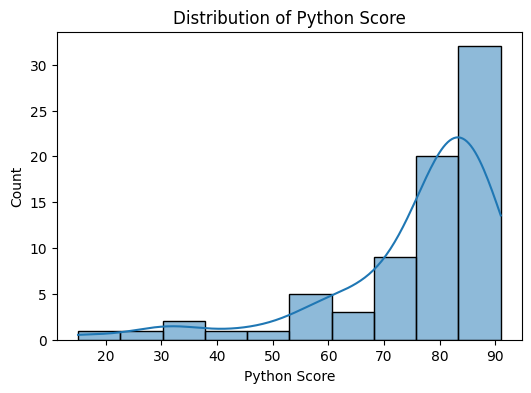

In [ ]:
#check Python column distribution
dist_df = df.groupby('DB').size().reset_index(name='count')                         
plt.figure(figsize=(6,4))
sns.histplot(df['Python'], bins=10, kde=True)
plt.xlabel('Python Score')
plt.ylabel('Count')
plt.title('Distribution of Python Score')
plt.show()                          #distribution shows wide-range 
                                    #however, the distribution is left-skewed with a long tail toward lower scores
                                    #median reflects the typical Python skill among students

Data Preprocessing & Cleaning

In [25]:
#use a staging dataframe for preprocessing
temp_df = df.copy()

#drop 'DB' column
temp_df = temp_df.drop(columns='DB')

#replacing NA values in 'Python' column
median_val = temp_df['Python'].median()
temp_df['Python'] = temp_df['Python'].fillna(median_val)
temp_df[temp_df['Python'].isna()]

#convert 'Python' column from float to int
temp_df['Python'] = temp_df['Python'].astype(int)

#standardizing values in identified columns
#gender
temp_df['gender'] = (
    temp_df['gender'].str.lower()
    .map({'m': 'Male', 'male': 'Male', 'f': 'Female', 'female': 'Female'})
    .fillna('Unknown')
)
temp_df['gender'].unique()

#country
def replace_country(name):
    if name in ('Rsa','UK','Norge'):
        if name == 'Rsa':
            return 'South Africa'
        elif name == 'UK':
            return 'United Kingdom'
        else:
            return 'Norway'
    else:
        return name.title()

temp_df['country'] = (temp_df['country'].apply(replace_country))
temp_df['country'].unique()

#residence
temp_df['residence'] = (
    temp_df['residence'].str.replace(r'bi[\s\-_]?residence','BI Residence', 
                                     flags=re.IGNORECASE, regex=True)
)
temp_df['residence'].unique()

#previous education
temp_df['prevEducation'] = temp_df['prevEducation'].replace({
    'HighSchool': 'High School',
    'Barrrchelors': 'Bachelors',
    'Diplomaaa': 'Diploma'
}).str.title()

#replace results back into df
df = temp_df.copy()

temp_df.head(15)


,fNAME,lNAME,Age,gender,country,residence,entryEXAM,prevEducation,studyHOURS,Python
0,Christina,Binger,44,Female,Norway,Private,72,Masters,158,59
1,Alex,Walekhwa,60,Male,Kenya,Private,79,Diploma,150,60
2,Philip,Leo,25,Male,Uganda,Sognsvann,55,High School,130,74
3,Shoni,Hlongwane,22,Female,South Africa,Sognsvann,40,High School,120,81
4,Maria,Kedibone,23,Female,South Africa,Sognsvann,65,High School,122,91
5,Hannah,Hansen,25,Female,Norway,BI Residence,66,High School,130,88
6,Ole,Johansen,27,Male,Norway,BI Residence,90,Bachelors,156,80
7,Lars,Olsen,29,Male,Norway,BI Residence,89,Bachelors,160,85
8,Bjørn,Larsen,31,Male,Norway,BI Residence,88,Bachelors,156,80
9,Sofie,Jensen,33,Female,Denmark,BI Residence,85,Bachelors,160,83


Data Exploratory Analysis (General Distribution)

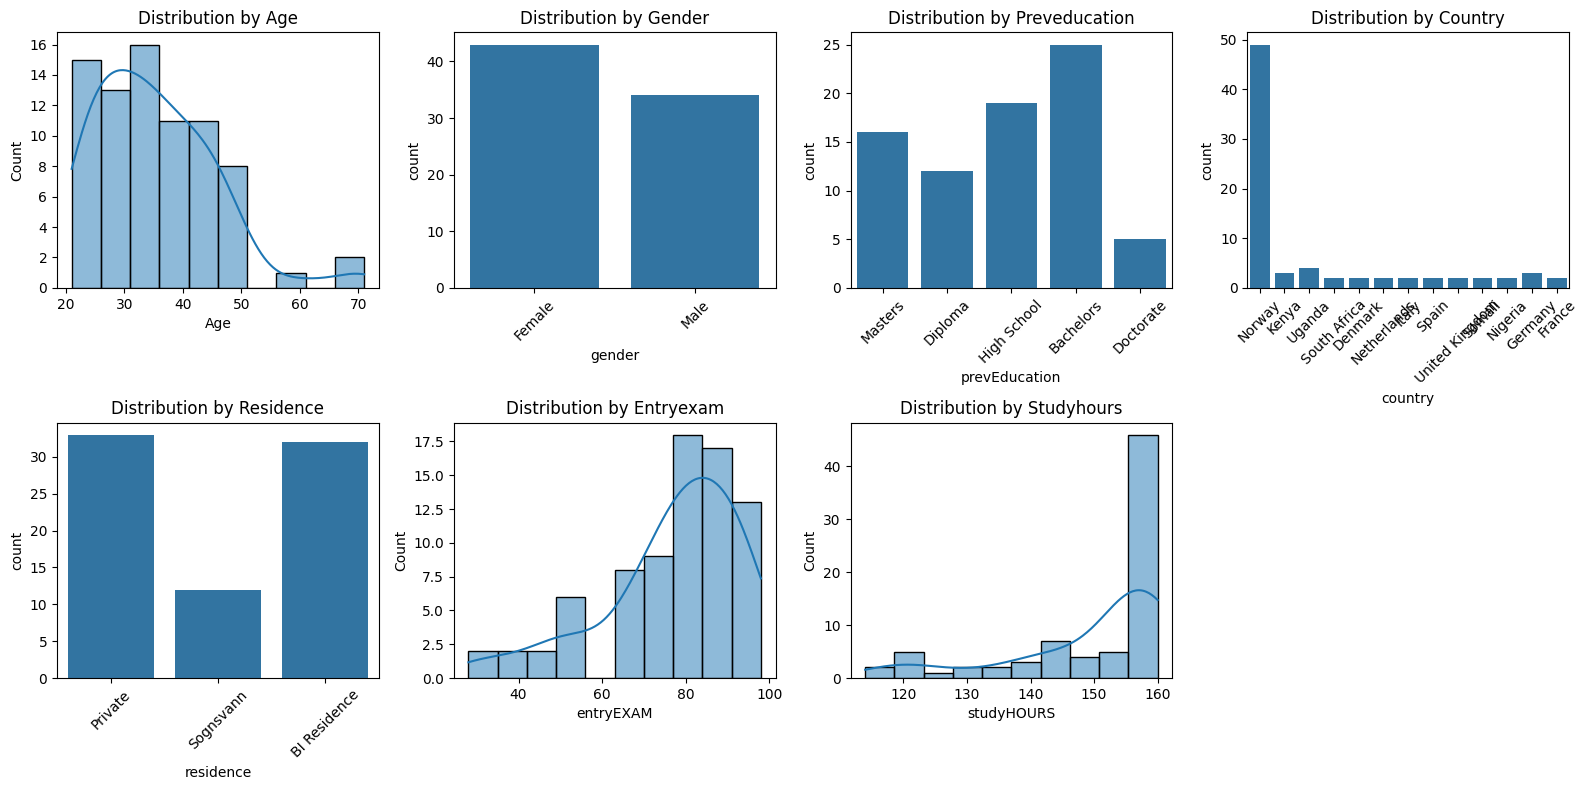

In [26]:
#histogram with KDE for categorical and countplot for numerical 
features = ['Age','gender','prevEducation','country','residence','entryEXAM','studyHOURS']
numerical_cols = ['Age','entryEXAM','studyHOURS']
categorical_cols = ['gender','prevEducation','country','residence']
rows = 2
cols = int(np.ceil(len(features) / rows))
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))  
axes = axes.flatten()
for i, col in enumerate(features):
    if col in numerical_cols:
        sns.histplot(temp_df[col], bins=10, kde=True, ax=axes[i])
    else:
        sns.countplot(x=col, data=temp_df, ax=axes[i])
        axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_title(f'Distribution by {col.title()}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Data Exploratory Analysis (Feature Significance Study)

                 df       sum_sq      mean_sq           F        PR(>F)
gender          1.0     1.627232     1.627232    0.041969  8.384492e-01
residence       2.0   511.380758   255.690379    6.594670  2.738555e-03
country        12.0  2072.227604   172.685634    4.453843  6.342839e-05
prevEducation   4.0  1769.206248   442.301562   11.407675  8.790541e-07
Age             1.0   143.447845   143.447845    3.699753  5.969922e-02
entryEXAM       1.0  8872.525456  8872.525456  228.836832  4.582329e-21
studyHOURS      1.0  2160.868814  2160.868814   55.732314  7.231370e-10
Residual       54.0  2093.703057    38.772279         NaN           NaN


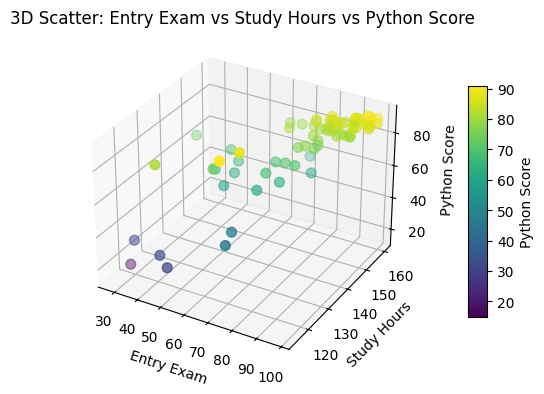

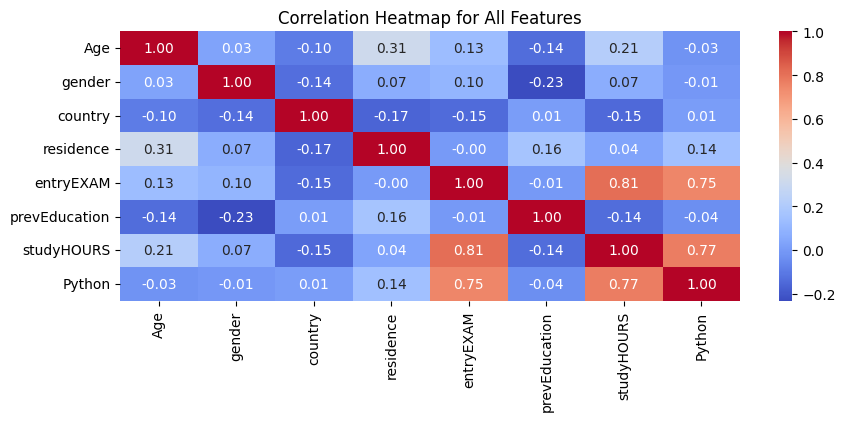

In [ ]:
#simple feature analysis using ANOVA 
model = ols('Python ~ gender + residence + country + prevEducation + Age + entryEXAM + studyHOURS', 
            data=df).fit()
anova_results = anova_lm(model)
print(anova_results)        #significant if p<0.05 and stronger if p<0.01
                            #based on these results entryEXAM and studyHOURS are most significant 
                            #residence, country, prevEducation are significant
                            #Age and gender are not significant

#3d scatter plot
x = df['entryEXAM']
y = df['studyHOURS']
z = df['Python']
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=z, cmap='viridis', s=50)
ax.set_xlabel('Entry Exam')
ax.set_ylabel('Study Hours')
ax.set_zlabel('Python Score')
ax.set_title('3D Scatter: Entry Exam vs Study Hours vs Python Score')

cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=12, pad=0.12)
cbar.set_label('Python Score')
plt.show()                  

#correlation heatmap
df_encoded = df.copy()
df_encoded = df_encoded.drop(columns=['fNAME','lNAME'])
categorical_cols = ['gender', 'residence', 'country', 'prevEducation']
le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])
corr_df = df_encoded.corr()

plt.figure(figsize=(10,3.5))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap for All Features')
plt.show()                  #studyhours and entryexam are highly correlated

#both studyhours and entry exam show strongest significance towards python score
#however, there are both correlated, indicating multicollinearity
#multicollinearity affects coefficient interpretability

Data Exploratory Analysis (Support Strategy)

Age                      33.5
entryEXAM              48.625
studyHOURS              124.0
gender                 Female
residence        BI Residence
country                Norway
prevEducation     High School
dtype: object


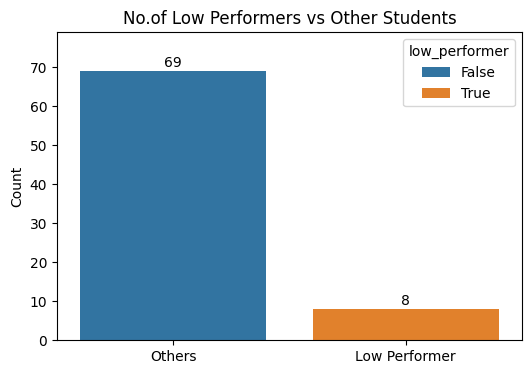

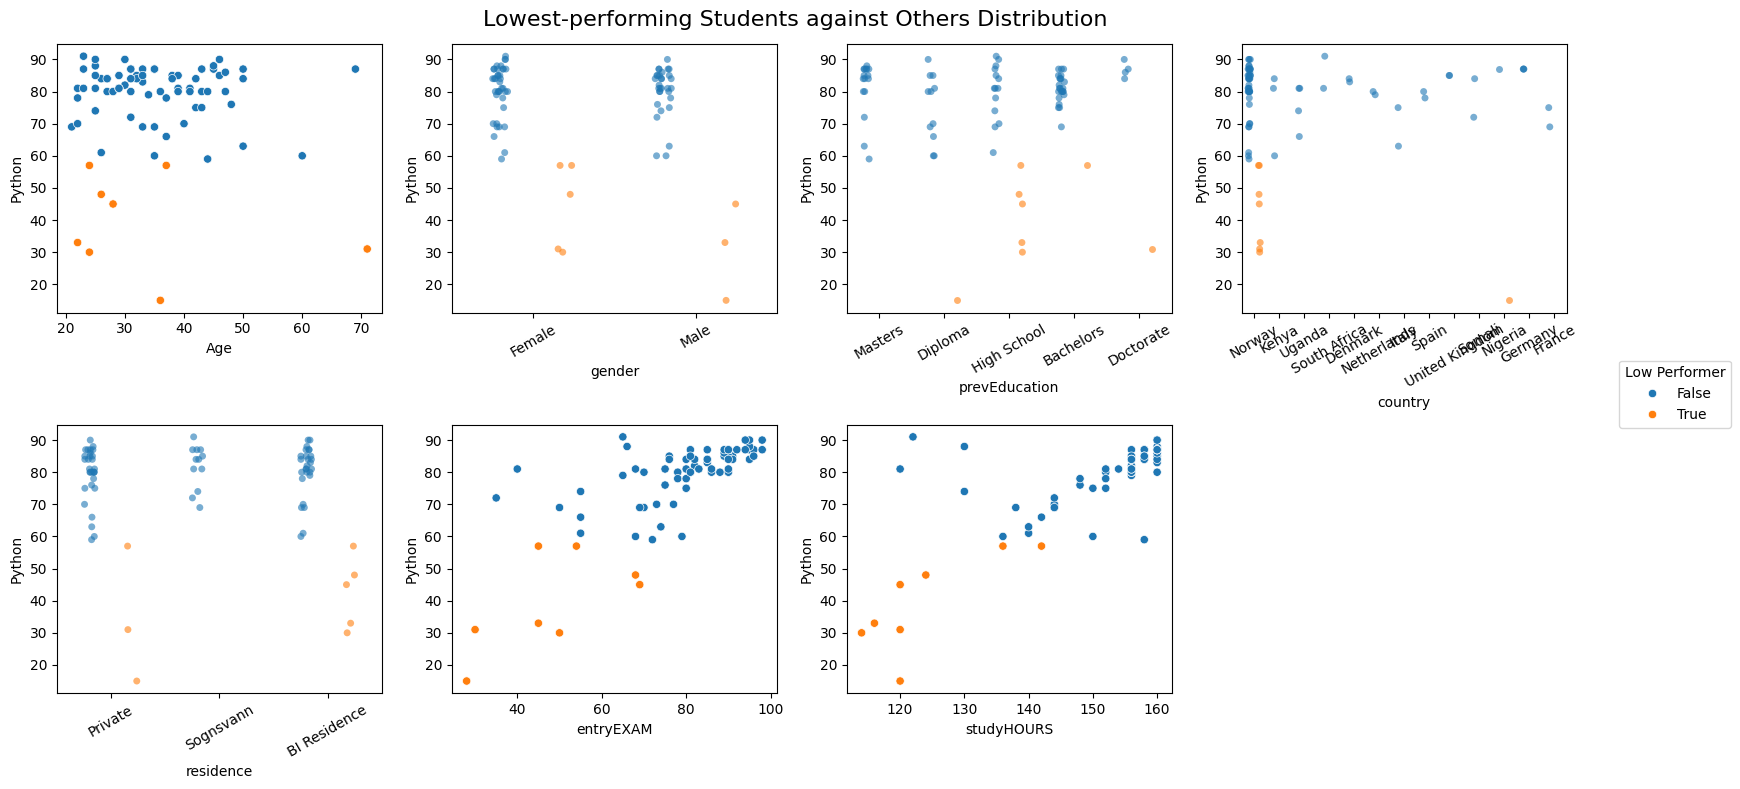

In [ ]:
#Python score distribution is left-skewed, with most students scoring higher
#therefore, the scoring quantile in Q1 would also be high 
#it is important to identify which is considered the cutoff for the business 
#the study below is only a case defined personally
#students who don't need help as much & student who perform well (cluster 1)
#bottom 10% students who really need help (cluster 2)

#defining the lowest performing students
low_cutoff = temp_df['Python'].quantile(0.10)      
temp_df['low_performer'] = temp_df['Python'] <= low_cutoff

#show average and mode for low performing students
low_df = temp_df[temp_df['low_performer'] == True]
low_summary = pd.concat([
    low_df[numerical_cols].mean(),
    low_df[categorical_cols].mode().iloc[0]
])
print(low_summary)
 
#plotting distribution of lowest performers vs others by percentage
counts = temp_df['low_performer'].value_counts().reset_index()
counts.columns = ['low_performer', 'count']

tick_labels = {True: 'Low Performer', False: 'Others'}
plt.figure(figsize=(6,4))
sns.barplot(x='low_performer', y='count', data=counts, hue='low_performer')
for i, row in counts.iterrows():
    plt.text(i, row['count'] + 1, f"{row['count']}", ha='center')
plt.xticks(ticks=range(len(counts)), labels=[tick_labels[val] for val in counts['low_performer']])
plt.ylabel('Count')
plt.xlabel('')
plt.title('No.of Low Performers vs Other Students')
plt.ylim(0, counts['count'].max()+10)
plt.show()

#use stripplot for categorical columns
#use scatterplot for numerical columns
features = ['Age','gender','prevEducation','country','residence','entryEXAM','studyHOURS']
numerical_cols = ['Age','entryEXAM','studyHOURS']
categorical_cols = ['gender','prevEducation','country','residence']

rows = 2
cols = int(np.ceil(len(features) / rows))
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = axes.flatten()
for i, col in enumerate(features):
    if col in numerical_cols:
        sns.scatterplot(x=col, y='Python', hue='low_performer', data=temp_df, ax=axes[i])
        axes[i].get_legend().set_visible(False)
    else:
        sns.stripplot(x=col, y='Python', hue='low_performer', data=temp_df, dodge=True, jitter=True, alpha=0.6, ax=axes[i])
        axes[i].tick_params(axis='x', rotation=30)
        axes[i].get_legend().set_visible(False)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Low Performer', bbox_to_anchor=(1.05, 0.5), loc='center')
plt.suptitle('Lowest-performing Students against Others Distribution', fontsize=16)
plt.tight_layout()
plt.show()

#a lot of similarities can be seen in the bottom 10% low-performing student cluster
#1 - most of them are from Norway
#2 - most of them belong to age group below 40
#3 - most of them have highest education 'High School'
#4 - most of them are 'BI Residence'
#5 - most of them scored below 60 in entry exam
#6 - most of them have low study hours
#these behavioural similiarities can be used as guideline for support strategies for lowest-performing students


Python Score Prediction

In [ ]:
#define features for predictive modelling
temp_df = df.copy()
features = ['Age','gender','prevEducation','country','residence','entryEXAM','studyHOURS']

#check variance influence factor
#high VIF -> coefficient increases due to collinearity with other predictors
X = pd.get_dummies(temp_df[features], drop_first=True)
X_numeric = X.astype(float)
vif_data = pd.DataFrame()
vif_data['feature'] = X_numeric.columns
vif_data['VIF'] = [variance_inflation_factor(X_numeric.values, i) for i in range(X.shape[1])]
vif_data = vif_data.sort_values(by='VIF', ascending=False).head(10)
print(vif_data)

#Age, entryEXAM and studyHOURS show high VIF
#Age is likely collinear with other highly correlated features (like older student have more studyhours etc)
#Drop Age column, and investigate entryEXAM / studyHOURS column

                      feature         VIF
2                  studyHOURS  191.886749
1                   entryEXAM   75.459061
0                         Age   54.262016
14             country_Norway   28.644093
20          residence_Private    6.805611
21        residence_Sognsvann    5.125526
18             country_Uganda    3.397535
7       prevEducation_Masters    3.147742
6   prevEducation_High School    3.138667
3                 gender_Male    2.889038


In [36]:
#predictive modelling
#test with multiple models

temp_df = df.copy()
top_countries = temp_df['country'].value_counts().nlargest(5).index
temp_df['country_grouped'] = temp_df['country'].where(temp_df['country'].isin(top_countries), 'Other')

features = ['gender', 'prevEducation', 'country_grouped', 'residence', 'studyHOURS']
categorical_cols = ['gender','prevEducation','country_grouped','residence']

X = pd.get_dummies(temp_df[features], columns=categorical_cols, drop_first=True)
y = temp_df['Python']

cv = KFold(n_splits=3, shuffle=True, random_state=42)
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=0.01, max_iter=10000),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

results = {}
best_folds = {}

for name, model in models.items():
    if name in ['Linear Regression', 'Ridge Regression', 'Lasso Regression']:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
    else:
        pipe = model  

    scores = cross_val_score(pipe, X, y, cv=cv, scoring='r2')
    results[name] = (scores.mean()*100, scores.std()*100)
    print(f"{name}: {scores.mean()*100:.2f}% ± {scores.std()*100:.2f}%")


#studyHOURS show better predictive result than entryEXAM and featured interactions
#countries are grouped because small dataset -> reduce sparse, multicollinearity

#on average, linear regression can explain 78% of the variance in Python scores, but because the dataset is small, 
#performance can vary by about 11 percentage points depending on which data is in the train/test split

Linear Regression: 78.46% ± 11.39%
Lasso Regression: 78.57% ± 11.44%
Ridge Regression: 78.42% ± 11.74%
Random Forest: 27.95% ± 40.66%
XGBoost: -3.86% ± 26.25%


In [45]:
y = temp_df['Python']
y_sd = y.std()  
mean_r2, std_r2 = results['Linear Regression']
mean_r2 = mean_r2 / 100
std_r2 = std_r2 / 100
residual_sd_mean = y_sd * np.sqrt(1 - mean_r2)
residual_sd_high  = y_sd * np.sqrt(1 - (mean_r2 - std_r2))
residual_sd_low = y_sd * np.sqrt(1 - (mean_r2 + std_r2))

print(f'Predicted residual standard deviation (error): {residual_sd_mean:.2f}')
print(f'Possible range due to CV: {residual_sd_low:.2f} - {residual_sd_high:.2f}')

#the expected prediction error is roughly (+/-) 7 points, and may vary between 5–9 points depending on the data split

Predicted residual standard deviation (error): 7.07
Possible range due to CV: 4.85 - 8.74


                         feature  coefficient
0                     studyHOURS    15.967634
9   country_grouped_South Africa     6.400399
12           residence_Sognsvann     3.242929
7         country_grouped_Norway     3.172851
4      prevEducation_High School     2.250016
10        country_grouped_Uganda     2.215647
8          country_grouped_Other     1.484286
5          prevEducation_Masters    -1.145818
6          country_grouped_Kenya    -0.759289
11             residence_Private    -0.292881
2          prevEducation_Diploma    -0.220047
1                    gender_Male     0.070121
3        prevEducation_Doctorate    -0.023606


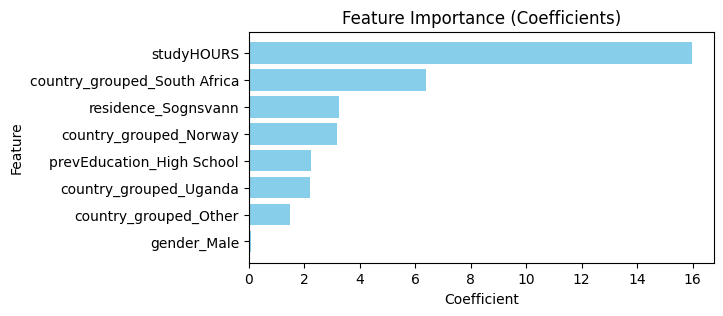

In [46]:
#check feature importance for the model
#identify how the changes to features result in better Python score
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
pipe.fit(X, y)

coef = pipe.named_steps['model'].coef_
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': coef
}).sort_values(by='coefficient', key=abs, ascending=False)
print(feature_importance)

feature_importance = feature_importance[feature_importance['coefficient'] > 0]
plt.figure(figsize=(6,3))
plt.barh(feature_importance['feature'], feature_importance['coefficient'], color='skyblue')
plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title('Feature Importance (Coefficients)')
plt.gca().invert_yaxis() 
plt.show()

#studyHOURS as key predictor 
#encouraging students to increase study time is likely the most impactful intervention

#investigate what resources or practices students in high-performing locations use
#residence Sognsvann has moderate effect
#potential factors involve distance from study location, study environments

#prior education level has minor influence, gender does not matter


In [ ]:
#apply Python score predictions
temp_df = df.copy()
top_countries = temp_df['country'].value_counts().nlargest(5).index
temp_df['country_grouped'] = temp_df['country'].where(temp_df['country'].isin(top_countries), 'Other')
features = ['gender', 'prevEducation', 'country_grouped', 'residence', 'studyHOURS']
categorical_cols = ['gender','prevEducation','country_grouped','residence']

X = pd.get_dummies(temp_df[features], columns=categorical_cols, drop_first=True)
y = temp_df['Python']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print('RMSE:', rmse)
print('R2:', r2)

#74% of the variance in Python scores are explained
#average difference of error between predicted values and actual about 9 (0-100) score

RMSE: 9.363280883757087
R2: 0.7469326575430276


In [ ]:
#compare improvement among bottom 10% students on predicted Python score
#with improvements on feasible important features
temp_df = df.copy()
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
temp_df['PredictedPython'] = y_pred.astype(int)

low_cutoff = temp_df['Python'].quantile(0.10)      
bottom_10_df = temp_df[temp_df['Python'] < low_cutoff].copy()
bottom_10_df['studyHOURS'] += 10
resi_col = [each for each in X.columns if each.startswith('residence')]
bottom_10_df[resi_col] = 0
bottom_10_df['residence_Sognsvann'] = 1
X_bottom = bottom_10_df.reindex(columns=X.columns, fill_value=0)
bottom_10_df['NewPredictedPython'] = model.predict(X_bottom).astype(int)

bottom_10_df['Improvement'] = bottom_10_df['NewPredictedPython'] - bottom_10_df['PredictedPython']
bottom_10_df[['PredictedPython', 'NewPredictedPython', 'Improvement']]

,PredictedPython,NewPredictedPython,Improvement
20,37,46,9
21,34,44,10
32,36,51,15
40,64,79,15
47,62,72,10
48,47,56,9
49,42,51,9
53,32,51,19
